## Проект: Статистический анализ данных

### Основная цель проекта: проанализировать данные сервиса аренды самокатов GoFast и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением.

Сервисом можно пользоваться:

без подписки:
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;

с подпиской Ultra:
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

### Описание данных

Пользователи — users_go.csv

- user_id — уникальный идентификатор пользователя
- name — имя пользователя
- age — возраст
- city — город
- subscription_type — тип подписки (free, ultra)

Поeздки — rides_go.csv

- user_id — уникальный идентификатор пользователя
- distance — расстояние, которое пользователь проехал в текущей сессии (в метрах)
- duration — продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- date — дата совершения поездки

Подписки — subscriptions_go.csv

- subscription_type — тип подписки
- minute_price — стоимость одной минуты поездки по данной подписке
- start_ride_price — стоимость начала поездки
- subscription_fee — стоимость ежемесячного платежа

### Основные этапы проекта:
- Изучить данные
- Привести их в пригодный для анализа формат
- Проверить предлагаемые гипотезы
- Сделать вывод на основе полученных результатов

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom

#### Шаг 1. Загрузка данных

1.1 Считаем CSV-файлы с данными зададим переменные, отобразим первые строки

In [2]:
# Загружаем датафреймы
try:
    users_go = pd.read_csv('/datasets/users_go.csv')
    rides_go = pd.read_csv('/datasets/rides_go.csv')
    subscriptions_go = pd.read_csv('/datasets/subscriptions_go.csv')
except:
    users_go = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
    rides_go = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
    subscriptions_go = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

1.2 Изучим общую информацию о каждом датафрейме

In [3]:
# Отображение всех колонок при выводе на печать
pd.set_option('display.max_columns', None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 412.6 KB
None

           user_id          age
count  1565.000000  1565.000000
mean    762.633866    24.922045
std     443.260155     4.553496
min       1.000000    12.000000
25%     378.000000    22.000000
50%     762.000000    25.000000
75%    1146.000000    28.000000
max    1534.000000    43.000000


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


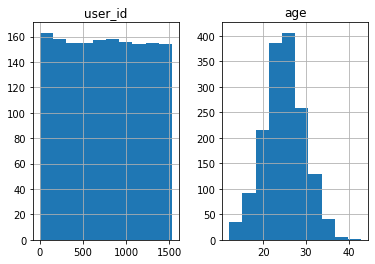

In [4]:
# Изучение датафрейма 'users_go' 
print(users_go.info(memory_usage='deep')) 
print()
print(users_go.describe())
users_go.hist()
users_go.head()

In [5]:
# Уникальные идентификаторы
print(len(users_go['user_id'].unique()), 'уникальных значений в', users_go['user_id'].count(), 'строках')
print('От', users_go['user_id'].min(), 'до', users_go['user_id'].max())

1534 уникальных значений в 1565 строках
От 1 до 1534


In [6]:
# Уникальные возрасты
print(len(users_go['age'].unique()), 'уникальных значений в', users_go['age'].count(), 'строках')
print('От', users_go['age'].min(), 'до', users_go['age'].max())

29 уникальных значений в 1565 строках
От 12 до 43


In [7]:
# Уникальные названия населенных пунктов
users_go['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [8]:
# Уникальные типы
users_go['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB
None

            user_id      distance      duration
count  18068.000000  18068.000000  18068.000000
mean     842.869936   3070.659976     17.805011
std      434.734317   1116.831209      6.091051
min        1.000000      0.855683      0.500000
25%      487.000000   2543.226360     13.597563
50%      889.000000   3133.609994     17.678395
75%     1213.250000   3776.222735     21.724800
max     1534.000000   7211.007745     40.823963


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


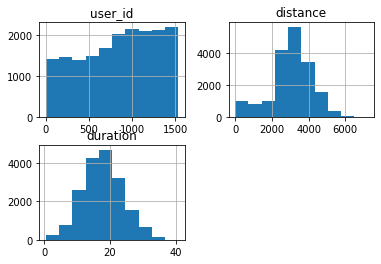

In [9]:
# Изучение датафрейма 'rides_go' 
print(rides_go.info())
print()
print(rides_go.describe())
rides_go.hist() 
rides_go.head()

In [10]:
# Уникальные идентификаторы
print(len(rides_go['user_id'].unique()), 'уникальных идентификаторов из', rides_go['user_id'].count(), 'строк')
print('От', rides_go['user_id'].min(), 'до', rides_go['user_id'].max())

1534 уникальных идентификаторов из 18068 строк
От 1 до 1534


In [11]:
# Изучение датафрейма 'subscriptions_go' 
print(subscriptions_go.info())
subscriptions_go.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes
None


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


#### Вывод по загрузке данных:
+ Датафрейм ‘users_go’ имеет 5 столбцов и 1565 строк без пропусков и выбросов. Названия столбцов соответствуют ‘змеиному’ стилю. Есть дубликаты идентификаторов в столбце ‘user_id’.
+ Датафрейм ‘rides_go’ имеет 4 столбца и 18068 строк без пропусков и выбросов. Названия столбцов соответствуют ‘змеиному’ стилю. Возможно наличие выбросов в столбцах ‘distance’ и ‘duration’.
+ Датафрейм 'subscriptions_go' имеет 4 столбца и 2 строки без пропусков и выбросов. Названия столбцов соответствуют ‘змеиному’ стилю.

#### Шаг 2. Предобработка данных

In [12]:
# Добавление столбца 'month' с номером месяца в датафейм 'rides_go'
rides_go['distance'] = rides_go['distance'].round(2)
rides_go['duration'] = np.ceil(rides_go['duration']).astype('int')
rides_go['date'] = pd.to_datetime(rides_go['date'], format='%Y-%m-%d')
rides_go['month'] = rides_go['date'].dt.month

In [13]:
print('Записи с ', rides_go['date'].min(), 'по', rides_go['date'].max())

Записи с  2021-01-01 00:00:00 по 2021-12-30 00:00:00


In [14]:
# Удаление дубликатов идентификаторов в столбце 'user_id' датафрейма 'users_go'
users_go = users_go.sort_values(by='user_id').loc[users_go['user_id'].duplicated() == False]

In [15]:
# Проверка наличия дубликатов в 'users_go'
users_go.sort_values(by='user_id').loc[users_go['user_id'].duplicated() == True].count()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [16]:
# Датафейм 'users_go'
users_go.info()
users_go.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 71.9+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  int64         
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 705.9 KB
None

   user_id  distance  duration       date  month
0        1   4409.92        26 2021-01-01      1
1        1   2617.59        16 2021-01-18      1
2        1    754.16         7 2021-04-20      4
3        1   2694.78        19 2021-08-11      8
4        1   4028.69        27 2021-08-28      8

            user_id      distance      duration         month
count  18068.000000  18068.000000  18068.000000  18068.000000
mean     842.869936   3070.659992     18.303520      6.486772
std      434

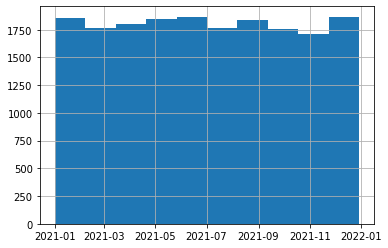

In [17]:
# Датафейм 'rides_go'
print(rides_go.info())
print()
print(rides_go.head())
print()
print(rides_go.describe())
print()
print('Анализ дат:')
print('Минимальная дата :', rides_go['date'].min())
print('Максимальная дата:', rides_go['date'].max())
rides_go['date'].hist()
plt.show()

Предобработка subscriptions_go не требуется.

#### Вывод по предобработке данных:
В процессе предобработки данных в датафрейме ‘rides_go’ был добавлен столбец ‘month’ и изменены типы данных столбцов. Также проверены данные в столбце с датами. Диапазон дат с 01.01.2021 по 30.12.2021. В пределах этого диапазона дат количество значений относительно равномерно распределено. Строки с дубликатами в поле ‘user_id’ удалены из ‘users_go’.

#### Шаг 3. Исследовательский анализ данных

3.1 Частота встречаемости городов

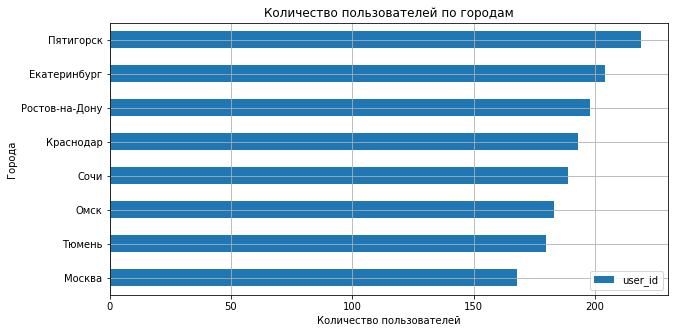

Количество пользователей по городам 


,user_id
city,
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


In [18]:
(
    users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=True)
    .plot(kind='barh', grid=True, figsize=(10, 5))
)
plt.title('Количество пользователей по городам')
plt.ylabel('Города')
plt.xlabel('Количество пользователей')

plt.show()
print('Количество пользователей по городам ') 
users_go.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', ascending=False)

Вывод по частоте встречаемости:

Лидером по частотности является Пятигорск (219 строк). Следом идут Екатеринбург (204 строки) и Ростов-на-Дону (198 строк). Замечено, что в первой половине располагаются в основном южные города, где сезон проката больше, за исключением Екатеринбурга.

3.2 Соотношение пользователей с подпиской и без подписки

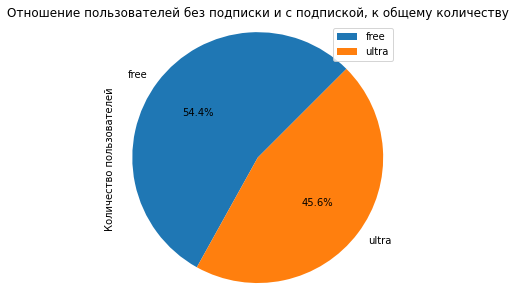

In [19]:
(
    users_go.pivot_table(index='subscription_type', values='user_id', aggfunc='count')
    .plot.pie(y='user_id', figsize=(5,5),  label='Количество пользователей', 
    autopct='%1.1f%%', startangle=45,
    title='Отношение пользователей без подписки и с подпиской, к общему количеству')

)
plt.axis('equal')
plt.show()

Вывод по соотношению пользователей с подпиской и без неё:

Пользователей с подпиской «free» 54.4% от общего количества, это юольше чем с подпиской «ultra» 45,6%.

3.3 Возраст пользователей

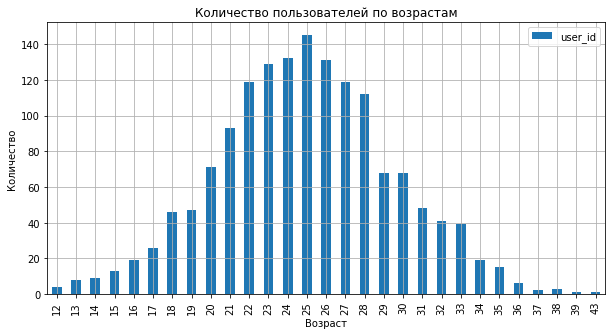

In [20]:
(
    users_go.pivot_table(index='age', values='user_id', aggfunc='count').sort_values(by='age', ascending=True)
    .plot(kind='bar' , grid=True, figsize=(10, 5))
)
plt.title('Количество пользователей по возрастам')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.show()

In [21]:
print('Средний возраст пользователей', users_go['age'].mean().round(1))
print('Медианный возраст пользователей', users_go['age'].median())
users_go['age'].describe()

Средний возраст пользователей 24.9
Медианный возраст пользователей 25.0


count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Вывод по возрасту пользователей:

Услугами сервиса аренды самокатов пользуются люди от 12 до 43 лет. Возрастная кривая имеет нормальное распределение. Максимальное количество пользователей в возрасте 25 лет, этот же возраст является медианным.

3.4 Расстояние, которое пользователь преодолел за одну поездку

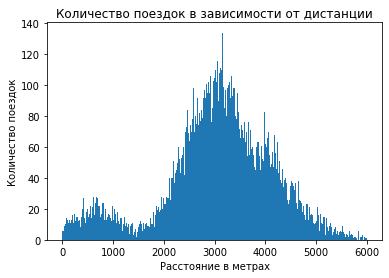

In [22]:
plt.hist(rides_go['distance'], bins=500, range=(1,6000))
plt.title('Количество поездок в зависимости от дистанции')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

In [23]:
rides_go['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

Вывод по расстоянию, которое польщователь преодолевает за одну поездку:

За одну поездку пользователи преодолевают до 7211 метров. Медиана всех значений равна 3133 метров. Наблюдаются два пика. Малый пик около 700 метров, большой пик около 3200 метров. Между пиками значения нормально распределены.

3.5 Продолжительность поездок

In [24]:
rides_go['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

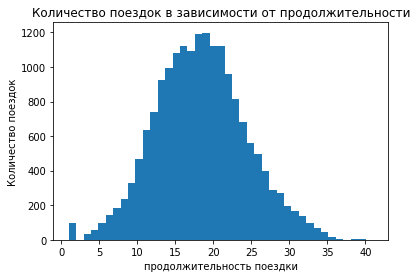

In [25]:
plt.hist(rides_go['duration'], bins=41, range=(1,41))
plt.title('Количество поездок в зависимости от продолжительности')
plt.xlabel('продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

Вывод по продолжительности поездок:

Продолжительность поездок нормально распределена от 0 до 41 минуты. Продолжительность в 18 минут является как средним так и медианным значением.
Наблюдается анамалия размером менее 100 поездок с продолжительностью в 1 минуту. Однако, они не являются выбрасами, т.к. подкреплены данными о поездках со столь же маленькими дистанциями.

#### Вывод по исследовательскому анализу данных:
+ Услугами сервиса аренды самокатов пользуются больше всего в южных городах, где сезон проката больше, но второй - Екатеринбург.
+ Количество пользователей без подписки free 54,4% превышает количество пользователей с подпиской ultra 45,6%.
+ Количество пользователей в зависимости от возраста указывает, что средний возраст подчиняется нормальному распределению с медианой в 25 лет, при этом средний возраст и медиана практически совпадают.
+ Количество поездок в зависимости от расстояния указывает, медиана поездок находится на 3133 метров первый квартиль находится на значении 2543 метра, третий квартиль на 3776 метров. Наблюдаются два пика. Малый пик около 700 метров, большой пик около 3200 метров. Между пиками значения нормально распределены.
+ Количество поездок в зависимости от продолжительности указывает, что медиана поездок находится на 18 мин, первый квартиль находится на значении 14 мин, третий квартиль на 22 мин. На гисторгамме замечено аномальное время поездок порядка 100 с временем меньше 1 минуты. 

#### Шаг 4. Объединение данных

4.1 Объединим данные о пользователях, поездках и подписках в один датафрейм. Для этого воспользуемся методом merge().

In [26]:
# Общая таблица с данными
total_go = users_go.merge(rides_go, on='user_id').merge(subscriptions_go, on='subscription_type')

In [27]:
total_go.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27,2021-08-28,8,6,0,199


In [28]:
print("Количество поездок в 'rides_go':", rides_go['user_id'].count())
print("Количество поездок в 'total_go':", total_go['user_id'].count())
print()
print("Количество уникальных пользователей в 'users_go':", len(users_go['user_id'].unique()))
print("Количество уникальных пользователей в 'total_go':", len(total_go['user_id'].unique()))

Количество поездок в 'rides_go': 18068
Количество поездок в 'total_go': 18068

Количество уникальных пользователей в 'users_go': 1534
Количество уникальных пользователей в 'total_go': 1534


In [29]:
total_go.duplicated().sum()

0

Вывод по объединению данных:

Созданный датафрейм df объединяющий таблицы rides_go, users_go, subscriptions_go в своем составе имеет 18068 строк во всех столбцах, что соответствует исходной таблице rides_go и указывает на отсутствие пропусков в столбцах. Дополнительно произведена проверка на явные дубликаты.

4.2 Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1:

4.2.1 С данными о пользователях без подписки

In [30]:
df_free = total_go[total_go['subscription_type'] == 'free']
df_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,15,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,17,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,21,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,10,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,18,2021-02-14,2,8,50,0


4.2.2 С данными о пользователях с подпиской

In [31]:
df_ultra = total_go[total_go['subscription_type'] == 'ultra']
df_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27,2021-08-28,8,6,0,199


In [32]:
# Проверим, что ничего не потеряли
if len(total_go) == (len(df_free) + len(df_ultra)):
    print('Всё хорошо')
else:
    print('Что-то не так')

Всё хорошо


4.3 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий

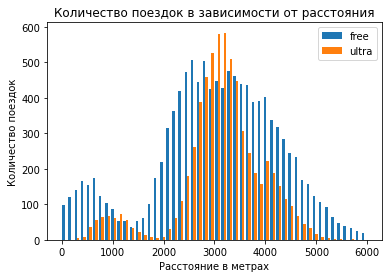

In [33]:
plt.hist([df_free['distance'], df_ultra['distance']], bins=50, range=(1,6000), label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Количество поездок в зависимости от расстояния')
plt.xlabel('Расстояние в метрах')
plt.ylabel('Количество поездок')
plt.show()

In [34]:
df_free['distance'].describe()

count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

In [35]:
df_ultra['distance'].describe()

count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

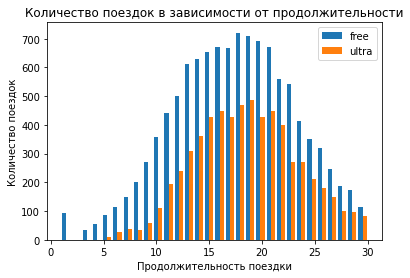

In [36]:
plt.hist([df_free['duration'], df_ultra['duration']], bins=30, range=(1,30), label=['free', 'ultra'])
plt.legend(loc='upper right')
plt.title('Количество поездок в зависимости от продолжительности')
plt.xlabel('Продолжительность поездки')
plt.ylabel('Количество поездок')
plt.show()

In [37]:
df_free['duration'].describe()

count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

In [38]:
df_ultra['duration'].describe()

count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

#### Вывод по объединению и визуализации данных пользователей без подписки free и с подпиской ultra
+ Визуализация датафреймов зависимости количества поездок на определенное расстояние и описательная статистика по пользователям без подписки free и с подпиской ultra указывает, что подписка влияет на медианные значения (расстояния поезки без подписки 3114.65 метров с подпиской 3148.64 метров), при этом у пользователей с подпиской меньше разброс (по стандартному отклонению free - 1246 ultra - 836), также маленький пик сместидся с 500 метров (free) до 1000 (ultra).
+ Визуализация датафреймов зависимости количества поездок за определенное время и описательная статистика по пользователям без подписки free и с подпиской ultra указывает, что подписка влияет на медианные значения (время поезки без подписки 18 мин с подпиской 19 мин), так же наблюдается снижение стандартного отклонения free - 6.33 ultra - 5.57.

#### Шаг 5. Подсчёт выручки

5.1 Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [39]:
users_months = total_go.pivot_table(
    index=('user_id', 'month', 'subscription_type'), 
    values=(
        'distance', 
        'duration', 
        'minute_price', 
        'start_ride_price', 
        'subscription_fee'), 
    aggfunc=({'distance':{'count', 'sum'}, 
             'duration':'sum',
             'minute_price': 'mean',
             'start_ride_price':'mean',
             'subscription_fee':'mean',}))

users_months.columns = [
    'count', 'distance', 
    'duration', 
    'minute_price',
    'start_ride_price', 
    'subscription_fee']

users_months.head()

count  distance  duration  minute_price  \
user_id month subscription_type                                            
1       1     ultra                  2   7027.51        42             6   
        4     ultra                  1    754.16         7             6   
        8     ultra                  2   6723.47        46             6   
        10    ultra                  2   5809.91        32             6   
        11    ultra                  3   7003.50        56             6   

                                 start_ride_price  subscription_fee  
user_id month subscription_type                                      
1       1     ultra                             0               199  
        4     ultra                             0               199  
        8     ultra                             0               199  
        10    ultra                             0               199  
        11    ultra                             0               199

5.2 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь

In [40]:
users_months['revenue'] = (
users_months['start_ride_price']*users_months['count']+
users_months['minute_price']*users_months['duration']+
users_months['subscription_fee'])

print ('Выручка за 2021 год составила :',users_months['revenue'].sum(), 'руб.')

Выручка за 2021 год составила : 3878641 руб.


#### Вывод по подсчёту выручки: 
Выручка сервиса аренды самокатов "GoFast" за год составила 3 878 641 руб.

#### Шаг 6. Проверка гипотез

6.1 Определим, тратят ли пользователи с подпиской больше времени на поездки

Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

Выдвинем гипотезы:

- Н0: Средняя продолжительность поездок с подпиской ultra и без free равна
- Н1: Средняя продолжительность поездок с подпиской ultra больше продолжительности поездок без подписок free

Проверим гипотезы, используем исходные данные о продолжительности каждой сессии — отдельно для тех у кого есть подписка и тех, у кого её нет.

In [41]:
alpha = 0.05

results = st.ttest_ind(
    df_ultra['duration'], 
    df_free['duration'], 
    equal_var=True, 
    alternative='greater')
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

2.4959453720736625e-34
Отвергаем нулевую гипотезу


Вывод по тратам в зависимости от подписки:

Нулевая гипотеза отвергнута, поэтому можем утверждать, что средняя продолжительность поездки с подпиской больше продолжительности поездок без подписки при установленном уровне значимости в 5 %.

6.2 Оптимальное растояние поездки с точки зрения износа самоката

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката.

Установим действительно ли, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Выдвинем гипотезы:

- Н0: Среднее расстояние поездок с подпиской ultra равно оптимальному расстоянию в 3130 метров.
- Н1: Среднее расстояние поездок с подпиской ultra больше оптимального в 3130 метров.

Проверим гипотезы, используем исходные данные о расстоянии для пользователей с подпиской.

In [42]:
distance = 3130
alpha = 0.05

results = st.ttest_1samp(
    df_ultra['distance'], 
    distance,
    alternative='greater')

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.9195362605842414
Не получилось отвергнуть нулевую гипотезу


Вывод по оптимальному растоянию поездки с точки зрения износа самоката:

Нулевую гипотезу не удалось отвергнуть и следовательно, можем утверждать, что среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстояние в 3130 метров с точки зрения износа самоката, при установленном уровне значимости в 5 %.

6.3. Определим, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Выдвинем гипотезы:
- Н0: Помесячная средняя выручка от пользователей с подпиской равна помесячной средней выручке от пользователей без подписки.
- Н1: Помесячная средняя выручка от пользователей с подпиской больше помесячной средней выручки от пользователей без подписки.

Проверим гипотезы, используем данные о выручке с подпиской и без подписки.

In [43]:
alpha = 0.05

results = st.ttest_ind(
    users_months.loc[users_months['subscription_fee'] > 0, 'revenue'], 
    users_months.loc[users_months['subscription_fee'] == 0, 'revenue'], 
    equal_var=True, 
    alternative='greater')
print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

1.8850394384715216e-31
Отвергаем нулевую гипотезу


Вывод по месячной выручке от пользователей с подпиской и без подписки:

Нулевая гипотеза отвергнута, можем утверждать, что средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки, при установленном уровне значимости в 5 %.

6.4. Разберем ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест нам понадобился бы для проверки этой гипотезы?

Сначала требуется провести сравнение выборок на предмет соответствия уникальных пользователей в них.

Если списки уникальных пользователей в них совпадают, то выборки зависимы и для проверки гипотезы применим метод scipy.stats.ttest_rel(before, after, alternative=’less’).

В ином случае, выборки не могут быть зависимы и для проверки гипотезы применим метод scipy.stats.ttest_ind(before, after, equal_var=False, alternative=’less’), где, equal_var=False, т.к. выборки не равны.

#### Вывод по проверке гипотез:
- Нулевая гипотеза отвергнута, есть основания утверждать, что средняя продолжительность поездки с подпиской больше продолжительности поездок без подписки при установленном уровне значимости в 5 %.
- Нулевую гипотезу не удалось отвергнуть, есть основания утверждать, что среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстояние в 3130 метров с точки зрения износа самоката, при установленном уровне значимости в 5 %.
- Нулевая гипотеза отвергнута, есть основания утверждать, что средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки, при установленном уровне значимости в 5 %.

#### Общий вывод по работе:
Загрузили 3 датафрейма: с пользователями, информацией о поездках, информацией о подписках.

Дальше проверили данные на пропуски, их не оказалось ни в одной таблице. Поменяли тип данных у столбца date из датафрейма rides_go к типу даты. Также добавили столбец month с номером месяца. И удалили дубликаты строк из датафрейма с пользователями.

Провели исследовательский анализ данных:
- Вывели, что количество пользователей по городам распределено примерно одинаково, нет выдающихся значений. Лидером по количеству пользователей является Пятигорск - 219 пользователей. Меньше всего пользователей в Москве - 168.
- Пользователей, использующих бесплатную подписку больше - 54% от общего числа пользователей. Платной подпиской пользуется 46%.
- Возраст пользователей в основном в промежутке от 20 до 30 лет.
- В основном пользователи проезжают от 2.5 км до 4 км.
- В основном длительность поездки состовляет 13 - 22 минут.

Объединили данные о пользователях, поездках и подписках в один датафрейм. На основе объединенного датафрейма создали еще 2 датафрейма:
- Для пользователей с подпиской
- Для пользователей без подписки

Визуализировали информацию о расстоянии и времени поездки для пользоватей каждого тарифа.

- Для бесплатного тарифа в основном время поездки составляет от 13 до 22 минут, и проезжают от 2 до 4 км.
- Для платного тарифа в основном время поездки составляет от 15 до 22 минут, и проезжают около 3 км.

Нашли суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц - вывели все данные в отдельный датафрейм users_months. Добавили в датафрейм users_months столбец с помесячной выручкой revenue.

Проверили гипотезы:
- Продолжительность поездки с подпиской больше продолжительности поездок без подписки.
- Среднее расстояние поездки пользователей с подпиской не превышает оптимальное расстояние в 3130 метров с точки зрения износа самоката.
- Средняя месячная выручка от пользователей с подпиской, больше средней месячной выручки от пользователей без подписки.

Рекомендации рекламному отделу: 
- Пользователи с подпиской являются более выгодными клиентами сервиса, поэтому стоит продвигать подписку Ultra.